# Lab 12.  Autoencoders and Generative Models

In this Lab we will focus on three different questions related to RNNs.

1) Autoencoders

2) Applications of generative methods and their combination


We will use material from the books:

"Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron. http://shop.oreilly.com/product/0636920052289.do 

- "Deep Learning with Python" by F. Chollet. https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438

which are recommended as Bibliography of the course.


We also use code that have been taken from the following souces:


- Keras blog (F. Chollet)  https://blog.keras.io/

- "Collection of generative models, e.g. GAN, VAE in Pytorch and Tensorflow." available from https://github.com/wiseodd/generative-models
The code there, and the comments available from https://wiseodd.github.io/  are an excellent source of knowledge and references about work on generative models. 
- Building Autoencoders in Keras. https://blog.keras.io/building-autoencoders-in-keras.html



In [1]:
# We start by importing the python libraries required to solve the problems

import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler


# Tensorflow library used for implementation of the DNNs
import tensorflow as tf

from keras.datasets import mnist, fashion_mnist
from keras.layers import Input, Dense , merge, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives


# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
def plot(samples,theshape):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in  enumerate(samples[:25,:]):    #enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(theshape), cmap='Greys_r')
        #plt.imshow(sample.reshape(theshape))

    return fig

In [3]:
# This function set the seeds of the tensorflow function
# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Autoencoder 


In the simplest Autoencoder (AE) model the goal is to learn to reconstruct the input. There is one hidden layer and the model is trained to produce an output identical to the input. If the number of neurons in the hidden layer is higher than the number of neurons in the input layer the AE is overcomplete. If it is smaller, the AE is undercomplete. 

We start by generating some data in three dimensions. From these data points we will select 100 points for training and  100 for test. 

In [4]:
rnd.seed(4)

# Number of points
m = 200

# The third variable will be depending on the first two 
# according to w1 and w2
w1, w2 = 0.1, 0.3

# There is some noise in the data
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

We select the train and test data and scale them. 

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

The data is visualized. Observed the semiring-like shape in the three-dimensional space.

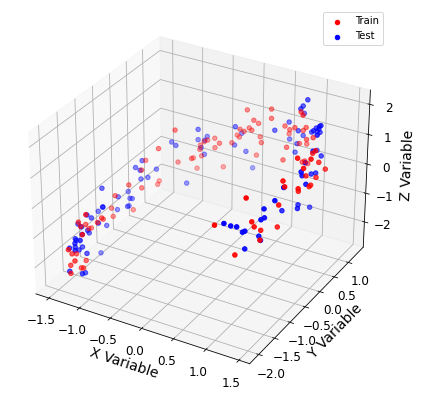

In [6]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')

# Training data is shown as red points. 
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], c='r', marker='o', label="Train")

# Test data is shown as blue points. 
ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c='b', marker='o', label="Test")

ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_zlabel('Z Variable')
plt.legend()
plt.show()

Finally, the AE is defined. It has a structure very similar to a MLP. The main difference is in the Loss function. 

Read carefully the different steps to define the AE below. In particular, notice the way the reconstruction loss is defined. 



In [7]:
# Since there are only three dimensions, the number of inputs is 3
n_inputs = 3

# Two neurons in the single hidden layers
n_hidden = 2  

# The number of inputs and outputs in the autoencoder is always the same
n_outputs = n_inputs


reset_graph()
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# Instead of defining the weights and biases, 
# and performing the matrix operation, we use the dense()
# function, that basically does the same.

hidden = tf.layers.dense(X, n_hidden, name='hidden_layer')
outputs = tf.layers.dense(hidden, n_outputs)

# The loss function is the mean-square error of the difference 
# between output and input
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

# Adam optimizer is used
optimizer = tf.train.AdamOptimizer(learning_rate)

# Minimization of the reconstruction loss 
training_op = optimizer.minimize(reconstruction_loss)

# The computation graph is initialized
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Finally the AE is run. We will store the output of the hidden layer  (only 2 dimensions) to inspect these values later.

In [8]:
# Number of iterations for the network
n_iterations = 1000
# Hidden layer 
codings = hidden

# We will keep the weights of the "hidden" layer in the variable "weights"
weights = tf.get_default_graph().get_tensor_by_name(os.path.split(hidden.name)[0] + '/kernel:0')

# The AE is run
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
        
    # We use the hidden layer as a function and it outputs
    # 2-dimensional representation of the input
    codings_val = codings.eval(feed_dict={X: X_test})
    reconstruction = outputs.eval(feed_dict={X: X_test})

    # We print the weights learned by the network
    print(weights.eval())
 

[[-0.5706081   1.5145422 ]
 [-0.8119004  -0.33110458]
 [-0.6980887   0.2632693 ]]


We visualize the output of the hidden layer (codings_val) which is a vector of two dimensions. This is the type of compress representation that AEs produce as a side-product and that it is very useful for dimensionality reduction. 

Finally, we print the two dimensional output of the hidden layer.  Notice the similarity to the original data in three  dimensions. In this example AE has shown its use as a dimensionality reduction method. 

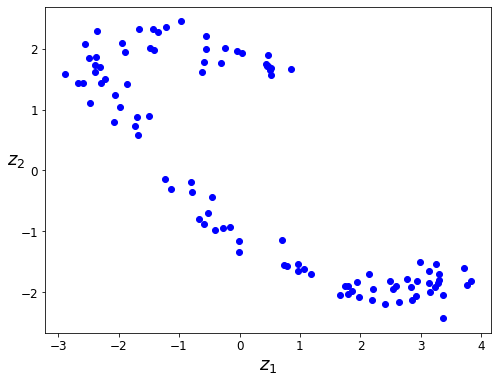

In [9]:
fig = plt.figure(figsize=(8,6))
plt.plot(codings_val[:,0], codings_val[:, 1], "bo")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

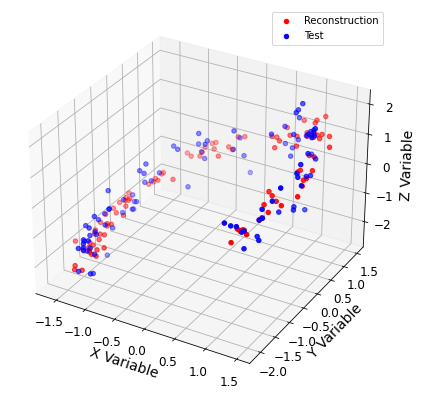

In [10]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')

# We visualize the reconstruction as red points. 
ax.scatter(reconstruction[:,0], reconstruction[:,1], reconstruction[:,2], c='r', marker='o', label="Reconstruction")

# Test data is shown as blue points. 
ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c='b', marker='o', label="Test")

ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_zlabel('Z Variable')
plt.legend()
plt.show()

## Autoencoding MNIST

The following auxiliary function is used to read the mnist and fashion datasets

In [11]:
def Read_And_Normalize_Image_Dataset(db_name='mnist', max_train_samples = 10000, max_test_samples = 10000):

    if db_name=='mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()               
    elif db_name=='fashion':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()        
        
    #print(x_train.shape,y_train.shape)
    #print(x_test.shape,y_test.shape)

        
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    #x_train = x_train.reshape((len(x_train), 28*28))
    #x_test = x_test.reshape((len(x_test), 28*28))

    return (x_train, y_train), (x_test, y_test) 

## Exercise 1.

- Modify the implementation in the previous example to learn an autoencoder for the MNIST dataset.

Note that the previous implementation was designed for a simple problem. You should modify the structure so that the reconstruction phase has sufficient information. For example, you could use 3 hidden layers of 400, 200, and 400 neurons each.

Suggestions:
- Use the function provided to read the mnist dataset.
- Check the quality of the implementation running the last cell.

In [14]:
tf.reset_default_graph()
n_inputs = 784

#Change these if you want to
n_hidden1 = 400
n_hidden2 = 200
n_hidden3 = 400

n_outputs = n_inputs

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# Instead of defining the weights and biases, 
# and performing the matrix operation, we use the dense()
# function, that basically does the same.

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden_layer1')
hidden2 = tf.layers.dense(hidden1, n_hidden2, name='hidden_layer2')
hidden3 = tf.layers.dense(hidden2, n_hidden3, name='hidden_layer3')
outputs = tf.layers.dense(hidden3, n_outputs)

# The loss function is the mean-square error of the difference 
# between output and input
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

# Adam optimizer is used
optimizer = tf.train.AdamOptimizer(learning_rate)

# Minimization of the reconstruction loss 
training_op = optimizer.minimize(reconstruction_loss)

# The computation graph is initialized
init = tf.global_variables_initializer()

In [16]:
(mnist_train, mnist_train_y), (mnist_test, mnist_test_y) = Read_And_Normalize_Image_Dataset()
mnist_train = np.reshape(mnist_train, (-1, 784))
mnist_test = np.reshape(mnist_test, (-1, 784))

In [17]:
# Number of iterations for the network
n_epochs = 80
save = np.arange(1, n_epochs+1, n_epochs//4)
saver = tf.train.Saver()
batch_size = int(mnist_train.shape[0]/50)

# The AE is run
with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        batch = 0
        while batch < mnist_train.shape[0]:
            _, ls = sess.run([training_op, reconstruction_loss], feed_dict={X: mnist_train[batch:batch+batch_size]})
            batch += batch_size
        if epoch in save:
            print(epoch, ls)
            saver.save(sess, "./MNIST_autoencoder" + str(epoch))

1 0.51198494
21 0.024324903
41 0.01339751
61 0.008953617


In [18]:
pred_MNIST = []

with tf.Session() as sess:
    for i in save:
        saver.restore(sess, "./MNIST_autoencoder" + str(i))
        pred_MNIST.append(sess.run(outputs, feed_dict={X: mnist_test}))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder1
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder21
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder41
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder61


In [19]:
# This function is used to see how the quality of the autoencoder has increased during the training phase


def plot_evolution(original, preds, c=False):
    plt.figure(figsize=(16,16))
    for i in np.arange(0,25,5):
        plt.subplot(5, 5, i + 1)
        plt.gca().axis('off')
        plt.imshow(original[i].reshape((28, 28)), cmap=plt.cm.gray_r)
        plt.gca().set_title('Original')
        plt.subplot(5, 5, i + 2)
        plt.gca().axis('off')
        plt.imshow(preds[0][i].reshape((28, 28)), cmap=plt.cm.gray_r)
        if c:
            plt.gca().set_title("Noisy")
        else:
            plt.gca().set_title("Rec., 1 iteration")
        plt.subplot(5, 5, i + 3)
        plt.gca().axis('off')
        plt.imshow(preds[1][i].reshape((28, 28)), cmap=plt.cm.gray_r)
        if c:
            plt.gca().set_title("Rec., 1 iteration")
        else:
            plt.gca().set_title("Rec., 2 iteration")
        plt.subplot(5, 5, i + 4)
        plt.gca().axis('off')
        plt.imshow(preds[2][i].reshape((28, 28)), cmap=plt.cm.gray_r)
        if c:
            plt.gca().set_title("Rec., 2 iteration")
        else:
            plt.gca().set_title("Rec., 3 iteration")
        plt.subplot(5, 5, i + 5)
        plt.gca().axis('off')
        plt.imshow(preds[3][i].reshape((28, 28)), cmap=plt.cm.gray_r)
        if c:
            plt.gca().set_title("Rec., 3 iteration")
        else:
            plt.gca().set_title("Rec., 4 iteration")
        plt.gca().axis('off')
    plt.suptitle('Evolution of the Autoencoder', fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.show()

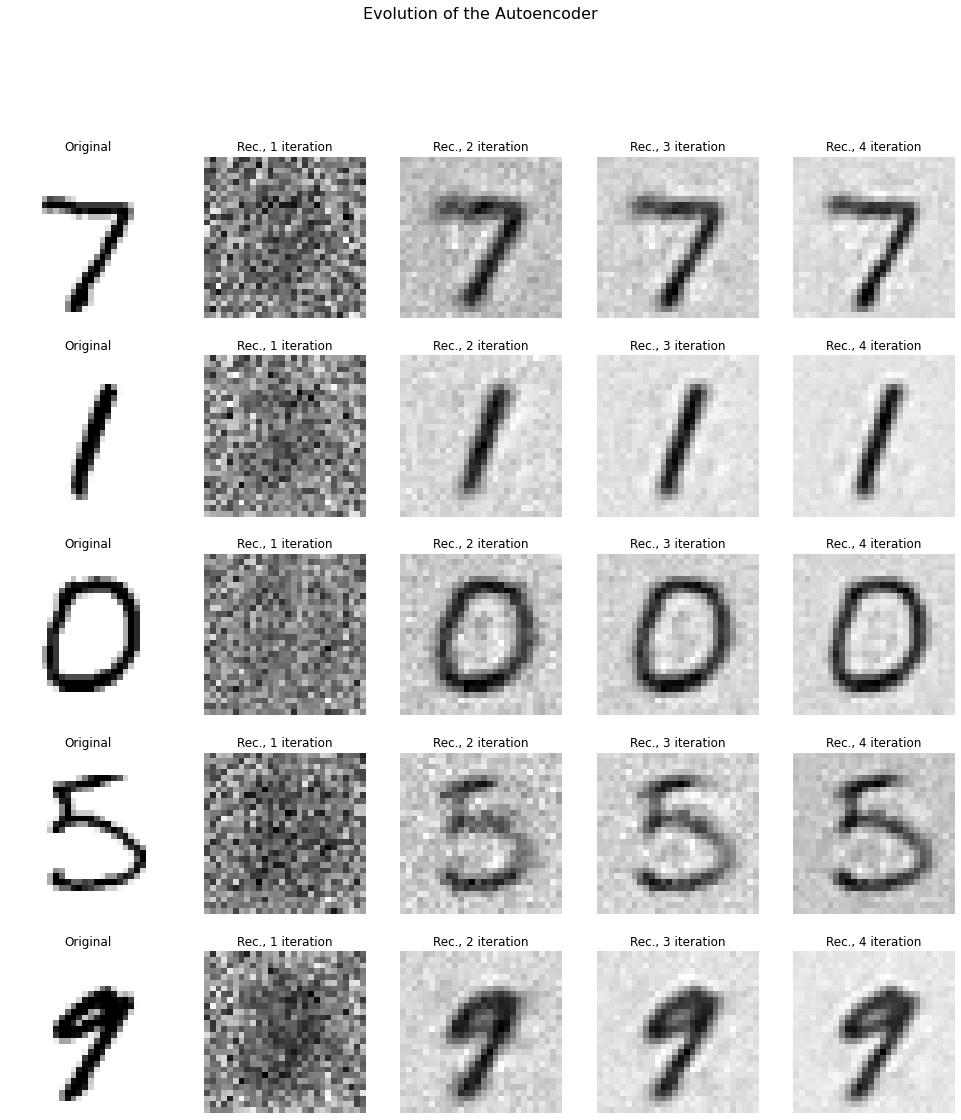

In [20]:
plot_evolution(mnist_test, pred_MNIST)

Now we are going to see how good the autoencoder trained with MNIST can reconstruct the fashion database

In [21]:
(fashion_train, fashion_train_y), (fashion_test, fashion_test_y) = Read_And_Normalize_Image_Dataset(db_name='fashion', max_train_samples = 10000, max_test_samples = 10000)
fashion_train = np.reshape(fashion_train, (-1, 784))
fashion_test = np.reshape(fashion_test, (-1, 784))

In [22]:
pred_fashion = []

with tf.Session() as sess:
    for i in save:
        saver.restore(sess, "./MNIST_autoencoder" + str(i))
        pred_fashion.append(sess.run(outputs, feed_dict={X: fashion_test}))

INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder1
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder21
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder41
INFO:tensorflow:Restoring parameters from ./MNIST_autoencoder61


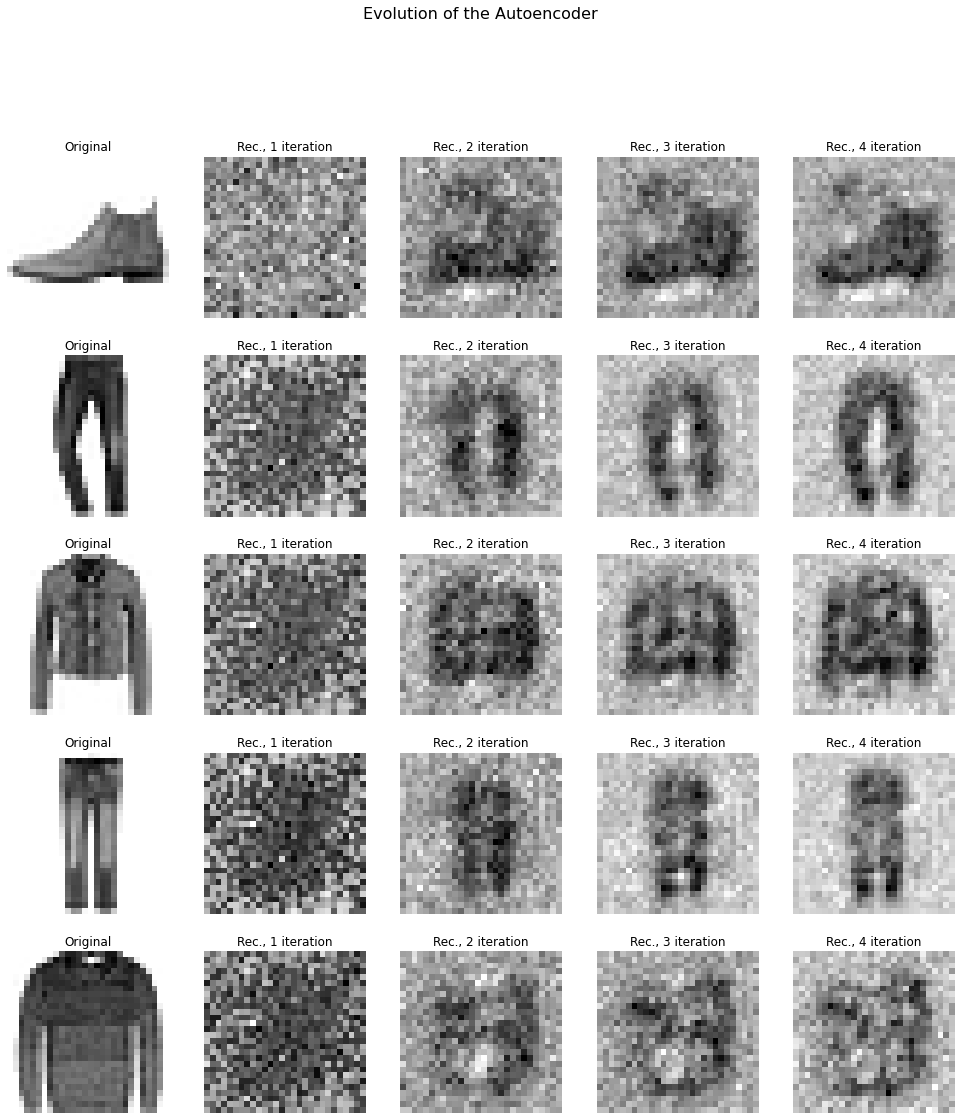

In [23]:
plot_evolution(fashion_test, pred_fashion)

## Exercise 2

As you can see, the reconstruction of the MNIST autoencoder for the fashion dataset is not very strong. Try to improve these results by training another autoencoder for the fashion dataset.

In [24]:
## This should be done in the exercise

n_inputs = 784


# These can be changed too. Note that this problem is al little more difficult. Maybe more layers/neurons than
# in the previous exercise are necessary
n_hidden1 = 400
n_hidden2 = 200
n_hidden3 = 400

In [26]:
# Defining the model
n_outputs = n_inputs

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

## Definition of the model
hidden1 = tf.layers.dense(X, n_hidden1)
hidden2 = tf.layers.dense(hidden1, n_hidden2)
hidden3 = tf.layers.dense(hidden2, n_hidden3)
outputs = tf.layers.dense(hidden3, n_outputs)

# The loss function is the mean-square error of the difference 
# between output and input
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

# Adam optimizer is used
optimizer = tf.train.AdamOptimizer(learning_rate)

# Minimization of the reconstruction loss 
training_op = optimizer.minimize(reconstruction_loss)

# The computation graph is initialized
init = tf.global_variables_initializer()

In [28]:
# Number of iterations for the network
n_epochs = 100
save = np.arange(1, n_epochs+1, n_epochs//4)
saver = tf.train.Saver()
batch_size = int(mnist_train.shape[0]/50)

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        batch = 0
        while batch < fashion_train.shape[0]:
            _, ls = sess.run([training_op, reconstruction_loss], feed_dict={X: fashion_train[batch:batch+batch_size]})
            batch += batch_size
        if epoch in save:
            print(epoch, ls)
            saver.save(sess, "./fashion_autoencoder" + str(epoch))

1 0.50365335


KeyboardInterrupt: 

In [ ]:
pred_fashion = []

with tf.Session() as sess:
    for i in save:
        saver.restore(sess, "./fashion_autoencoder" + str(i))
        pred_fashion.append(sess.run(outputs, feed_dict={X: fashion_test}))

In [ ]:
plot_evolution(fashion_test, pred_fashion)

## Denoising autoencoder


Denoising autoencoders (DAE) are very similar to AEs but they are trained to recover a "corrupted" input. This means that some noise will added to the input for training, but the corresponding output will be kept without any noise.

The key point in this DAE implementation is that the noise is added to the input of the network. 

We will use a dataset of chinese characters. It contains images of around 9000 chinese characters. The original dataset from which these images have been produced is available from: https://github.com/skishore/makemeahanzi

Check that you have the folder "chinese" that contains this dataset and run the following cells. 

In [29]:
chinese_char = np.load('chinese/chinese_characters.npy')
chinese_char = chinese_char.reshape((-1, 784))
chinese_test = chinese_char[:chinese_char.shape[0]//4]
chinese_train = chinese_char[chinese_char.shape[0]//4:]

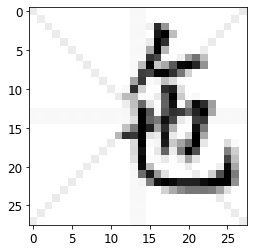

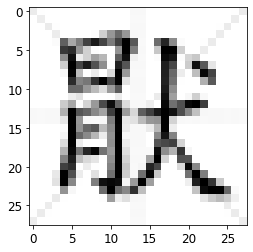

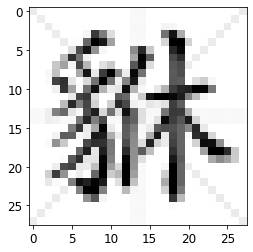

In [30]:
plt.imshow(chinese_char[10].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()
plt.imshow(chinese_char[20].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()
plt.imshow(chinese_char[30].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()

In [31]:
n_inputs = 784

n_hidden1 = 400
n_hidden2 = 200
n_hidden3 = 400

n_outputs = n_inputs


reset_graph()
learning_rate = 0.001
noise_level = 10
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

X_noisy = X + noise_level * tf.random_normal(tf.shape(X))


hidden1 = tf.layers.dense(X_noisy, n_hidden1, name='hidden_layer1')
z = tf.layers.dense(hidden1, n_hidden2, name='z')
hidden2 = tf.layers.dense(z, n_hidden3, name='hidden_layer2')
outputs = tf.layers.dense(hidden2, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
saver = tf.train.Saver()
# Adam optimizer is used
optimizer = tf.train.AdamOptimizer(learning_rate)

# Minimization of the reconstruction loss 
training_op = optimizer.minimize(reconstruction_loss)

# The computation graph is initialized
init = tf.global_variables_initializer()

In [32]:
# Number of iterations for the network
n_epochs = 500
save = np.arange(1, n_epochs+2, n_epochs//2)
print(save)
saver = tf.train.Saver()
batch_size = int(chinese_train.shape[0]/50)


with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+2):
        batch = 0
        while batch < chinese_train.shape[0]:
            _, ls = sess.run([training_op, reconstruction_loss], feed_dict={X: chinese_train[batch:batch+batch_size]})
            batch += batch_size
            
        if epoch in save:
            print(epoch, ls)
            saver.save(sess, "./chinese_DAE" + str(epoch))

[  1 251 501]
1 3279.222


KeyboardInterrupt: 

In [ ]:
pred_chinese = []

with tf.Session() as sess:
    for i in save:
        saver.restore(sess, "./chinese_DAE" + str(i))
        pred_chinese.append(sess.run(outputs, feed_dict={X: chinese_test}))
    pred_chinese = [sess.run(X_noisy, feed_dict={X: chinese_test})] + pred_chinese

We compare the predictions of the network for MNIST

In [ ]:
plot_evolution(chinese_test, pred_chinese, c=True)

## Exercise 3

In the previous example, we have assumed that the noise the DAE is going to face is known, and we have therefore trained it to deal with this specific kind of noise - both the training and testing data were *generated* with the same noise function.

In this exercise, we are going to test a more realistic problem, in which we are applying two kinds of noise to the training and testing data:

- With the same training and testing separation that we have made, modify the example so that you *manually* introduce noises - with numpy, for example.
    - The two choosen noises should be different, for example, random uniform, and random normal
- Train a DAE with the training data with one noise
- Test the DAE with the test data with the other noise


In [ ]:
n_inputs = 784

n_hidden1 = 400
n_hidden2 = 200
n_hidden3 = 400

n_outputs = n_inputs


reset_graph()
learning_rate = 0.001

noise_level = 20

chinese_train_noisy = chinese_train + 
chinese_test_noisy = chinese_test + 

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = 
z =
hidden2 = 
outputs =

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
saver = tf.train.Saver()
# Adam optimizer is used
optimizer = tf.train.AdamOptimizer(learning_rate)

# Minimization of the reconstruction loss 
training_op = optimizer.minimize(reconstruction_loss)

# The computation graph is initialized
init = tf.global_variables_initializer()

In [ ]:
# Number of iterations for the network
n_epochs = 500
save = np.arange(1, n_epochs+2, n_epochs//2)
print(save)
saver = tf.train.Saver()
batch_size = int(chinese_train_noisy.shape[0]/50)


with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+2):
        batch = 0
        while batch < chinese_train.shape[0]:
            _, ls = sess.run([training_op, reconstruction_loss], feed_dict={X: chinese_train_noisy[batch:batch+batch_size]})
            batch += batch_size
            
        if epoch in save:
            print(epoch, ls)
            saver.save(sess, "./chinese_DAE" + str(epoch))

In [ ]:
pred_chinese = []

with tf.Session() as sess:
    for i in save:
        saver.restore(sess, "./chinese_DAE" + str(i))
        pred_chinese.append(sess.run(outputs, feed_dict={X: chinese_test}))
    pred_chinese = [chinese_test_noisy] + pred_chinese

In [ ]:
plot_evolution(chinese_test, pred_chinese, c=True)

## Generative Modeling

Now we will focus on Generative Models. In particular we analyze:
1. GAN  
2. Variational Autoencoders (VAEs)

### Defining a GAN model for the MNIST dataset

In the example below we define a GAN model to generate images from the MNIST dataset. We will define the Discriminator and the Generator components and the loss-function that we want to optimize. 

In [ ]:
n_inputs = 28*28                   # The number of inputs to the network n_inputs=28*28=784
n_G_noise = 100                    # The size of the noise input for the Generator
n_D_hidden_ouputs = 128            # The size of the hidden layer in the Discriminator
n_G_hidden_ouputs = 128            # The size of the hidden layer in the Generator


# xavier_init is a function to randomly initialize the weights of neurons.
def xavier_init(size):  # Normal version
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


Now we define the Discriminator. It will be a multilayer perceptron of only one hidden layer and one output layer. 

In [ ]:

# The input variable
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# The hidden layer of the discriminator. It receives n_inputs=784 and 
# outputs n_D_hidden_ouputs=128 values. 
# Here the weights and bias are defined
D_W1 = tf.Variable(xavier_init([n_inputs, n_D_hidden_ouputs]))
D_b1 = tf.Variable(tf.zeros(shape=[n_D_hidden_ouputs]))

# The discriminator output layer. It receives n_inputs=128 and 
# outputs only one value [PROB. OF WHETHER THE INPUT IMAGE IS FAKE OR NOT]

D_W2 = tf.Variable(xavier_init([n_D_hidden_ouputs, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

# These theta_D values are all the parameters of the model.
theta_D = [D_W1, D_W2, D_b1, D_b2]

# Finally the discriminator is defined. Notice that it computes
# the output probability using a sigmoid function
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit



Now we define the Generator. It will be a multilayer perceptron of only one hidden layer and one output layer. 

In [ ]:
# Z is the noise vector, needed to generate samples from the generator
Z = tf.placeholder(tf.float32, shape=[None, n_G_noise])

# The hidden layer of the Generator. It receives n_G_noise=100 and 
# outputs n_G_hidden_ouputs=128 values. 
# Here the weights and bias are defined
G_W1 = tf.Variable(xavier_init([n_G_noise, n_G_hidden_ouputs]))
G_b1 = tf.Variable(tf.zeros(shape=[n_G_hidden_ouputs]))

# The generator output layer. It receives n_G_hidden_ouputs=100 noise values
# outputs a FAKE input vector (an invented MNIST image)

G_W2 = tf.Variable(xavier_init([n_G_hidden_ouputs, n_inputs]))
G_b2 = tf.Variable(tf.zeros(shape=[n_inputs]))

# These theta_G values are all the parameters of the model.
theta_G = [G_W1, G_W2, G_b1, G_b2]

# Z is randomly sampled between -1 and 1
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

# This is the generator that receive a noise vector
# and using the generator component outputs a sample
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob



Definition of the loss functions and optimization algorithms. 

In [ ]:
# We will get samples from the generator
G_sample = generator(Z)

# We get the discriminator to get the probabilities (and logits)
# of the real input and of the fake G_sample
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# Alternative loss functions 
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Loss functions 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, 
                                                                     labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake,
                                                                     labels=tf.zeros_like(D_logit_fake)))
# For the discriminator the total loss is the sum of the two
D_loss = D_loss_real + D_loss_fake

# For the generator, we want to change G_sample in such a way that it gets
# a higher probability from the Discriminator
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, 
                                                                labels=tf.ones_like(D_logit_fake)))

# The problems are solved 
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)



Finally, we create the tensorflow session and run the algorithm

In [ ]:
# Batch size
mb_size = 250
Z_dim = 100
number_iterations = 41
batch_size = 150
n_batches = mnist_train.shape[0]//batch_size
print_cycle = 8


sess = tf.Session() 
sess.run(tf.global_variables_initializer())

if not os.path.exists('gan_out/'):
    os.makedirs('gan_out/')

for it in range(number_iterations):

        
    # 25 random samples are taken from the generator for visualization purposes
    samples = sess.run(G_sample, feed_dict={Z: sample_Z(25, Z_dim)})

    # They are saved in the directory gan_out
    fig = plot(samples,[28,28])
    plt.savefig('gan_out/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
    plt.close(fig)
        
    for i in range(n_batches):

        # A batch is picked from MNIST    
        X_mb = mnist_train[i*batch_size:(i+1)*batch_size]

        # The training data is used to train the GAN
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % print_cycle == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()


## Exercise 4

Answer the following questions:

1. What is the meaning of using the loss function tf.nn.sigmoid_cross_entropy_with_logits for the discriminator? Explain the way it is used. 

2. What is the meaning of using the loss function tf.nn.sigmoid_cross_entropy_with_logits for the generator? Explain the way it is used. 

3. Go to the directory gan_out. What do the figures show? Can you identify any pattern as the generation advances?


Suggestion:

You can see tensorflow help.

### Dataset for the Second Exercise

For this exercise, we are going to change the dataset to a more *realistic* one, using images of coins to train a GAN



In [ ]:
# Coins DataSet  (See https://github.com/despoisj/CoinsDataset for details on dataset)
x_train = np.load('coin_images.npy')
x_train = x_train/255
print(x_train.shape)
fig = plot(x_train,[50,50])
plt.show()

## Exercise 5

Modify the following cells to run a GAN on the selected dataset. 

1.  Take into account the number of samples in the dataset and the number of variables for deciding on the batch size, the number of input variables, and the number of iterations. Add at least one layer compared to the previous example, as this problem is significantly more difficult.
2. Modify the name of the folder where the samples from the generator are going to be saved
3. Inspect the images generated by the GAN
4. Evaluate the effect of adding a hidden layer to the generator and discriminator modules
5. After completing the runs for the assigned dataset, select another dataset of your choice and repeat the experiment. 

In [ ]:
n_inputs =                    # The number of inputs to the network 
n_G_noise =                     # The size of the noise input for the Generator
n_D_hidden_ouputs =             # The size of the hidden layer in the Discriminator
n_G_hidden_ouputs =             # The size of the hidden layer in the Generator


# xavier_init is a function to randomly initialize the weights of neurons.
def xavier_init(size):  # Normal version
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


In [ ]:

# The input variable
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# The hidden layer of the discriminator. 
# Here the weights and bias are defined


# The discriminator output layer.


# These theta_D values are all the parameters of the model.
theta_D = 

# Finally the discriminator is defined. Notice that it computes
# the output probability using a sigmoid function
def discriminator(x):
    

    return D_prob, D_logit



In [ ]:
# Z is the noise vector, needed to generate samples from the generator
Z = tf.placeholder(tf.float32, shape=[None, n_G_noise])

# The hidden layer of the Generator.


# The generator output layer. 


# These theta_G values are all the parameters of the model.
theta_G = 

# Z is randomly sampled between -1 and 1
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

# This is the generator that receive a noise vector
# and using the generator component outputs a sample
def generator(z):

    return G_prob



In [ ]:
# We will get samples from the generator


# We get the discriminator to get the probabilities (and logits)
# of the real input and of the fake G_sample


# Alternative loss functions 
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Loss functions 
D_loss_real = 
D_loss_fake = 
# For the discriminator the total loss is the sum of the two
D_loss = D_loss_real + D_loss_fake

# For the generator, we want to change G_sample in such a way that it gets
# a higher probability from the Discriminator
G_loss = 

# The problems are solved 
D_solver = tf.train.AdamOptimizer(0.001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(0.001).minimize(G_loss, var_list=theta_G)



In [ ]:
# Batch size
mb_size = 250
number_iterations = 41
batch_size = 150
n_batches = x_train.shape[0]//batch_size
print_cycle = 8


sess = tf.Session() 
sess.run(tf.global_variables_initializer())

if not os.path.exists('gan_out/'):
    os.makedirs('gan_out/')

for it in range(number_iterations):

        
    # 25 random samples are taken from the generator for visualization purposes
    samples = sess.run(G_sample, feed_dict={Z: sample_Z(25, n_G_noise)})

    # They are saved in the directory gan_out
    fig = plot(samples,[50,50])
    plt.savefig('gan_out/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
    plt.close(fig)
    
        
    for i in range(n_batches):
        

        # A batch is picked from MNIST    
        X_mb = x_train[i*batch_size:(i+1)*batch_size]

        # The training data is used to train the GAN
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, n_G_noise)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, n_G_noise)})

    if it % print_cycle == 0:
        print('Iter: {}'.format(it))
        #print(sess.run(D_loss_fake, feed_dict={Z: sample_Z(mb_size, n_G_noise)}))
        #print(sess.run(D_loss_real, feed_dict={X: X_mb}))
        #print(sess.run(D_real, feed_dict={X: X_mb, Z: sample_Z(mb_size, n_G_noise)}))
        #print(sess.run(D_fake, feed_dict={X: X_mb, Z: sample_Z(mb_size, n_G_noise)}))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()



For the last part of the exercise, try to train a GAN with one of the following datasets

In [ ]:
# Chinese Characters Dataset
#x_train = np.load('chinese/chinese_characters.npy')
#x_train = x_train.reshape((-1,784))
#print(x_train.shape)
#fig = plot(x_train,[28,28])
#plt.show()

#Short Texture DataSet  (see https://www.robots.ox.ac.uk/~vgg/data/dtd/ for details on original data)
#There are 47 textures represented 
#x_train = np.load('texture_images.npy')
#x_train = x_train/255.
#print(x_train.shape)
#fig = plot(x_train,[50,50])
#plt.show()

### Variational Auto-Encoder

The variational autoencoder contains two components. The encoder learns the conditional distribution of a latent variable z given the observed variable x (the inputs). A neural network acts as the encoder and it is assumed that the prior probability of the latent variant z follows a Normal distribution. The decoder, also a deep neural network, takes samples generated by a distribution parametrized by the results of the encoder and produces samples similar to those in our data.

The encoder and decoder will be represented as neural network of one hidden layer. Before advancing to see the VAE implementation remind of the VAE structure looking at the image in the following cell and/or slides from the class. 



The following image is taken from http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html, a blog which is a good introduction to VAEs.


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://fastforwardlabs.github.io/blog-images/miriam/imgs_code/vae.4.png", width=600, height=200)

### VAE Implementation

In [ ]:
# Some of the networks parameters are defined

# Number of variables (784)
X_dim = mnist_train.shape[1]

# Dimension of the latent variable z
z_dim = 100

# Size of the hidden layer
h_dim = 128


c = 0
lr = 1e-3

In the next cell the encoder is defined. It is a network that receives an input vector and outputs two vectors of latent variables. 

1) A vector of mu values. 

2) A vector of $log(\sigma^2)$ values

In [ ]:

# =============================== Q(z|X) ======================================

# Input variables
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# Output variables
z = tf.placeholder(tf.float32, shape=[None, z_dim])

# Input layer (weights and biases)
Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# Mean layer (weights and biases)
Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

# Variance layer (weights and biases)
Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


# The network computation is implemented 
def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

# Creates a sample from the Normal distribution defined by parameters mu and log_var
def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


In the next cell the decoder is implemented. It is a network of only one hidden layer. It receives samples from the Normal distribution and ouputs a sample from the input space

In [ ]:
# =============================== P(X|z) ======================================

# Hidden layer
P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# Output layer
P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


# The network computations are made. Notice that both,
# the logits and the probability computed from it are output
def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits



In the next cells the loss function and optimizers are defined. 

In [ ]:
# =============================== TRAINING ====================================

# The parameters of the latent distribution that 
# are learned from the encoder
z_mu, z_logvar = Q(X)

# The sample that is obtained sampling from 
# the latent distribution
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

######## Loss Functions ##################

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X))

# D_KL(Q(z|X) || P(z)); compute in closed form
kl_loss = 0.5 * tf.reduce_mean(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar)

# VAE loss
vae_loss = recon_loss + kl_loss

# The Adam optimizer is used
solver = tf.train.AdamOptimizer().minimize(vae_loss)

The tensorflow session is initialized and the simulation is run. 

In [ ]:

# Minibatch size
mb_size = 150
number_iterations = 101
n_batches = mnist_train.shape[0]//mb_size
print_cycle = 10


sess = tf.Session() 
sess.run(tf.global_variables_initializer())

# Some samples from the latent space are saved in the directory vae_out

if not os.path.exists('single/'):
    os.makedirs('single/')


for it in range(number_iterations):

    for batch in range(n_batches):
        X_mb = mnist_train[batch*mb_size:(batch+1)*mb_size]
        _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % print_cycle == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(25, z_dim)})

        fig = plot(samples,[28,28])
        plt.savefig('single/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)


In [ ]:
# Coins DataSet  (See https://github.com/despoisj/CoinsDataset for details on dataset)
#x_train = np.load('coin_images.npy')
#x_train = x_train/255.
#print(x_train.shape)
#fig = plot(x_train,[50,50])


# Chinese Characters Dataset
x_train = np.load('chinese/chinese_characters.npy')
x_train = x_train/255.
x_train = x_train.reshape((-1, 784))
print(x_train.shape)
fig = plot(x_train,[28,28])
plt.show()


#Short Texture DataSet  (see https://www.robots.ox.ac.uk/~vgg/data/dtd/ for details on original data)
#There are 47 textures represented 
#x_train1 = np.load('texture_images.npy')
#x_train1 = x_train1/255.
#print(x_train1.shape)
#fig = plot(x_train1,[50,50])

# Fashion Dataset (Remember update the directory where your fashion data is)
x_train1 = fashion_train
fig = plot(x_train1,[28,28])
plt.show()

combined_data = np.vstack((x_train,x_train1))

np.random.shuffle(combined_data)

fig = plot(combined_data,[28,28])
plt.show()



## Exercise 6

Modify the following cells to run a VAE on another dataset.


1.  Take into account the number of samples in the dataset and the number of variables for deciding on the batch size, the number of input variables, and the number of iterations
2. Modify the name of the folder where the samples from the generator are going to be saved 
3. Inspect the images generated by the VAE
4. Evaluate the effect of adding a hidden layer to the encoder and decoder modules.
5. After completing the runs for the assigned dataset, select another dataset of your choice and repeat the experiment. 

In [ ]:
# Some of the networks parameters are defined

reset_graph()

# Number of variables (784)
X_dim = combined_data.shape[1]
#y_dim = mnist.train.labels.shape[1]

# Dimension of the latent variable z
z_dim = 100

# Size of the hidden layer
h_dim = 128


c = 0
lr = 1e-3



# =============================== Q(z|X) ======================================




# =============================== P(X|z) ======================================




# =============================== TRAINING ====================================


######## Loss Functions ##################




In [ ]:

# Minibatch size
mb_size = 150
number_iterations = 300
n_batches = combined_data.shape[0]//mb_size
print_cycle = 20

sess = tf.Session() 
sess.run(tf.global_variables_initializer())

# Some samples from the latent space are saved in the directory vae_out

if not os.path.exists('combined/'):
    os.makedirs('combined/')

i = 0

for it in range(number_iterations):
    for batch in range(n_batches):
        X_mb = combined_data[batch*mb_size:(batch+1)*mb_size]

        _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % print_cycle == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(25, z_dim)})

        fig = plot(samples,[28,28])
        plt.savefig('combined/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)


## Exercise 7

Learn VAEs from combinations of datasets

1. Inspect the images generated by the VAE
2. Compare them with those obtained with single datasets


IMPORTANT: For the large_texture dataset, you should use only a subset of the images, preferably between 1200 and 3600 images, for example large_texture_data[2400:3600,:]

### VAE in Keras

Once again, we see how the Keras abstraction can help us at the time of designing *simple* models.
In this example, we are defining a VAE for the MNIST problem with **z** of size only two, so that we can do some visualization of the latent representation.

Additionally, we will visualize a 2D manifold of the data. In our case, the digits.

In [ ]:
batch_size = 100

# Dimension of the original data 28x28
original_dim = 784

# Number of neurons in the hidden layer
intermediate_dim = 50

# Latent dimension (only 2 variables for easier visualization)
latent_dim = 2

# Stardard deviation for the normal distribution
epsilon_std = 0.01



## ENCODER
# Input to the encoder
x = Input(batch_shape=(batch_size, original_dim))
# hidden layer of the encoder
h = Dense(intermediate_dim, activation='relu')(x)
# Output of the encoder (the mean and std)
z_mean = Dense(latent_dim//2)(h)
z_log_sigma = Dense(latent_dim//2)(h)

# Using the mean and the variance new samples
# of the hidden variables are generated

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# It transforms the sampling function into a layer of the network
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])


# DECODER

# Defines the hidden layer of the decoder 
decoder_h = Dense(intermediate_dim, activation='relu')
# Defines the ouput layer of the decoder
decoder_mean = Dense(original_dim, activation='sigmoid')
# The hidde layer receives outputs from the gaussian distribution
h_decoded = decoder_h(z)
# The output layer decodes the transformed z values into x 
x_decoded_mean = decoder_mean(h_decoded)


# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, [z_mean, z_log_sigma])

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)



In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
n_epochs = 10
vae.fit(mnist_train, mnist_train,
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(mnist_test, mnist_test))


We use the hidden representation to visualize th points in the 10 different classes. It can be seen that examples for the same class (the same color) are, at least to some extent, grouped together. 

In [ ]:
mnist_test_encoded = encoder.predict(mnist_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(mnist_test_encoded[0][:, 0], mnist_test_encoded[1][:, 0], c=mnist_test_y)
plt.colorbar()
plt.show()

Now we explore the space of latent representation, we create a grid of values in [-15,15] for the two latent variables and using all possible combinations we decode the variable X from the decoder. We observe how the classes of the problems are represented in the latent representation. 

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

## Exercise 8

Learn a VAE for the fashion data

1) Plot how points are grouped in the latent representation.

2) Display the how the classes of the problem are organized in the latent representation (as in the example above)

In [ ]:
batch_size = 100

# Dimension of the original data 28x28
original_dim = 784

# Number of neurons in the hidden layer
intermediate_dim = 50

# Latent dimension (only 2 variables for easier visualization)
latent_dim = 2

# Stardard deviation for the normal distribution
epsilon_std = 0.01



## ENCODER
# Input to the encoder
x = Input(batch_shape=(batch_size, original_dim))
# hidden layer of the encoder
h = Dense(intermediate_dim, activation='relu')(x)
# Output of the encoder (the mean and std)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# Using the mean and the variance new samples
# of the hidden variables are generated

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# It transforms the sampling function into a layer of the network
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])


# DECODER

# Defines the hidden layer of the decoder 
decoder_h = Dense(intermediate_dim, activation='relu')
# Defines the ouput layer of the decoder
decoder_mean = Dense(original_dim, activation='sigmoid')
# The hidde layer receives outputs from the gaussian distribution
h_decoded = decoder_h(z)
# The output layer decodes the transformed z values into x 
x_decoded_mean = decoder_mean(h_decoded)


# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, [z_mean, z_log_sigma])

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)



In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
n_epochs = 10
vae.fit()


In [ ]:
fashion_test_encoded = encoder
plt.figure(figsize=(6, 6))
plt.scatter(, , c=)
plt.colorbar()
plt.show()

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

##  Exercise 9 

Below there is an implementation of the VAE when the number of latent variables is 20. 

1) Use the chinese dataset to learn the VAE

2) Generate data from the VAE and evaluate its quality (you  can use the function predict() and the function plot() to visualize the data.


In [ ]:
batch_size = 25

# Dimension of the original data 28x28
original_dim = 

# Number of neurons in the hidden layer
intermediate_dim = 50

# Latent dimension (only 2 variables for easier visualization)
latent_dim = 

# Stardard deviation for the normal distribution
epsilon_std = 0.01


## ENCODER
# Input to the encoder
x = Input(batch_shape=(batch_size, original_dim))
# hidden layer of the encoder
h = Dense(intermediate_dim, activation='relu')(x)
# Output of the encoder (the mean and std)
z_mean = Dense()()
z_log_sigma = Dense()()

# Using the mean and the variance new samples
# of the hidden variables are generated

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# It transforms the sampling function into a layer of the network
z = 


# DECODER

# The hidde layer receives outputs from the gaussian distribution
h_decoded = Dense(intermediate_dim, activation='relu')(z)
# The output layer decodes the transformed z values into x 
x_decoded = Dense(original_dim, activation='sigmoid')(h_decoded)


# end-to-end autoencoder
vae = Model()

# encoder, from inputs to latent space
encoder = Model()

# decoder, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)



In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
# Chinese Characters Dataset
chinese = np.load('chinese/chinese_characters.npy')
chinese = chinese.reshape((-1,784))
chinese_train = chinese[:9000,:]
chinese_test = chinese[9000:,:]

chinese_train = chinese_train.astype('float32') / 255.  #+ 1/255.
chinese_test = chinese_test.astype('float32') / 255.  # + 1/255.
    
print(chinese_train.shape,chinese_test.shape)
fig = plot(chinese_train,[28,28])
#plt.show()

In [ ]:
n_epochs = 40

vae.fit()

In [ ]:
samples = 

In [ ]:
plot(samples, [28, 28])